In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
with np.load('./mnist.npz') as data:
    X_train = data['x_train']
    y_train = data['y_train']
    X_test = data['x_test']
    y_test = data['y_test']

In [43]:
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

In [44]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train, 10)
y_test = one_hot_encode(y_test, 10)

In [45]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(len(indices) * (1 - test_size))
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [46]:
def initialize_weights(input_size, output_size):
    W = np.random.randn(input_size, output_size) * 0.01
    b = np.zeros((1, output_size))
    return W, b

In [47]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

In [48]:
def forward_propagation(X, W, b):
    Z = np.dot(X, W) + b
    A = softmax(Z)
    return Z, A

In [49]:
def backward_propagation(X, Y, Z, A, W):
    m = X.shape[0]
    dZ = A - Y
    dW = np.dot(X.T, dZ) / m
    db = np.sum(dZ, axis=0, keepdims=True) / m
    return dW, db

In [50]:
def update_weights(W, b, dW, db, learning_rate):
    W -= learning_rate * dW
    b -= learning_rate * db
    return W, b

In [51]:
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

In [52]:
def train_node(X_train, y_train, X_val, y_val, output_size, learning_rate, epochs):
    input_size = X_train.shape[1]
    W, b = initialize_weights(input_size, output_size)
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    for epoch in range(epochs):
        Z, A = forward_propagation(X_train, W, b)
        Z_val, A_val = forward_propagation(X_val, W, b)
        train_loss = -np.mean(y_train * np.log(A + 1e-8))
        val_loss = -np.mean(y_val * np.log(A_val + 1e-8))
        train_acc = accuracy(np.argmax(A, axis=1), np.argmax(y_train, axis=1))
        val_acc = accuracy(np.argmax(A_val, axis=1), np.argmax(y_val, axis=1))
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)
        dW, db = backward_propagation(X_train, y_train, Z, A, W)
        W, b = update_weights(W, b, dW, db, learning_rate)
        
    return W, b, training_loss, validation_loss, training_accuracy, validation_accuracy

In [53]:
class TreeNeuralNetwork:
    def __init__(self, max_depth=3, learning_rate=0.1, epochs=50):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.nodes = []
        self.node_metrics = []

    def add_node(self, X_train, y_train, X_val, y_val):
        W, b, train_loss, val_loss, train_acc, val_acc = train_node(
            X_train, y_train, X_val, y_val, output_size=10, 
            learning_rate=self.learning_rate, epochs=self.epochs
        )
        self.nodes.append((W, b))
        self.node_metrics.append((train_loss, val_loss, train_acc, val_acc))
    
    def fit(self, X_train, y_train, X_val, y_val):
        self.add_node(X_train, y_train, X_val, y_val)
        for depth in range(1, self.max_depth):
            misclassified_train = X_train
            misclassified_val = X_val
            misclassified_y_train = y_train
            misclassified_y_val = y_val

            for W, b in self.nodes:
                _, A_train = forward_propagation(misclassified_train, W, b)
                _, A_val = forward_propagation(misclassified_val, W, b)

                train_preds = np.argmax(A_train, axis=1)
                val_preds = np.argmax(A_val, axis=1)

                misclassified_train_idx = np.where(train_preds != np.argmax(misclassified_y_train, axis=1))[0]
                misclassified_val_idx = np.where(val_preds != np.argmax(misclassified_y_val, axis=1))[0]

                misclassified_train = misclassified_train[misclassified_train_idx]
                misclassified_y_train = misclassified_y_train[misclassified_train_idx]
                misclassified_val = misclassified_val[misclassified_val_idx]
                misclassified_y_val = misclassified_y_val[misclassified_val_idx]

            if len(misclassified_train) == 0:
                break
            
            self.add_node(misclassified_train, misclassified_y_train, misclassified_val, misclassified_y_val)

    def predict(self, X):
        final_preds = np.zeros((X.shape[0], 10))
        for W, b in self.nodes:
            _, A = forward_propagation(X, W, b)
            final_preds += A
        return np.argmax(final_preds, axis=1)
    
    def summarize(self):
        for i, (train_loss, val_loss, train_acc, val_acc) in enumerate(self.node_metrics):
            print(f"Node {i+1}:")
            print(f"  Final Training Loss: {train_loss[-1]:.4f}")
            print(f"  Final Validation Loss: {val_loss[-1]:.4f}")
            print(f"  Final Training Accuracy: {train_acc[-1]:.4f}")
            print(f"  Final Validation Accuracy: {val_acc[-1]:.4f}")
        print("\nOverall Model Test Accuracy: {:.4f}".format(test_accuracy))

In [54]:
tree_nn = TreeNeuralNetwork(max_depth=6, learning_rate=0.1, epochs=50)
tree_nn.fit(X_train, y_train, X_val, y_val)

In [55]:
y_pred = tree_nn.predict(X_test)
test_accuracy = accuracy(y_pred, np.argmax(y_test, axis=1))
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8645


In [56]:
def plot_tree_metrics(tree_nn):
    for i, (train_loss, val_loss, train_acc, val_acc) in enumerate(tree_nn.node_metrics):
        epochs = len(train_loss)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(epochs), train_loss, label=f'Node {i+1} Training Loss')
        plt.plot(range(epochs), val_loss, label=f'Node {i+1} Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Node {i+1} Loss vs. Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(epochs), train_acc, label=f'Node {i+1} Training Accuracy')
        plt.plot(range(epochs), val_acc, label=f'Node {i+1} Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Node {i+1} Accuracy vs. Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

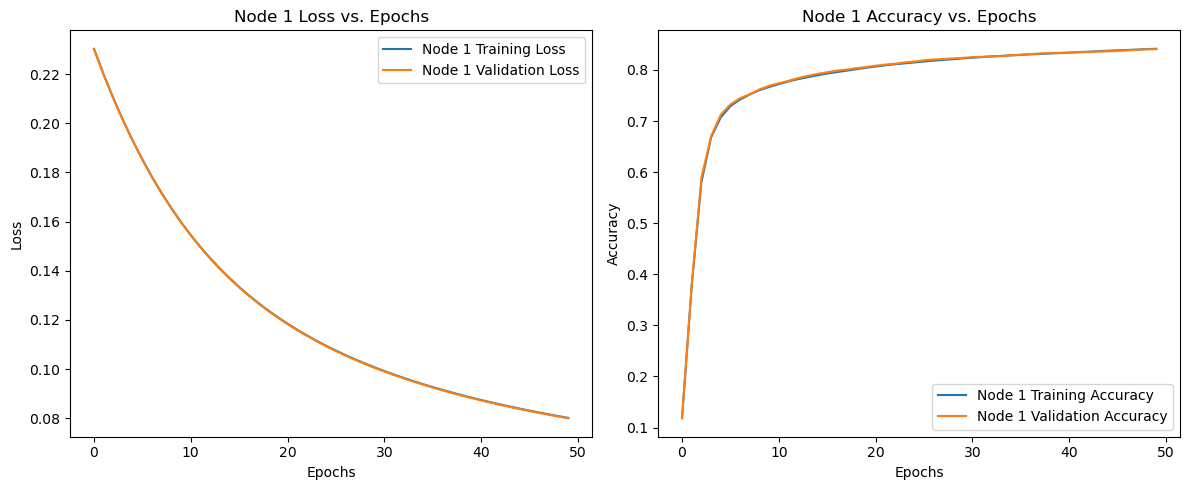

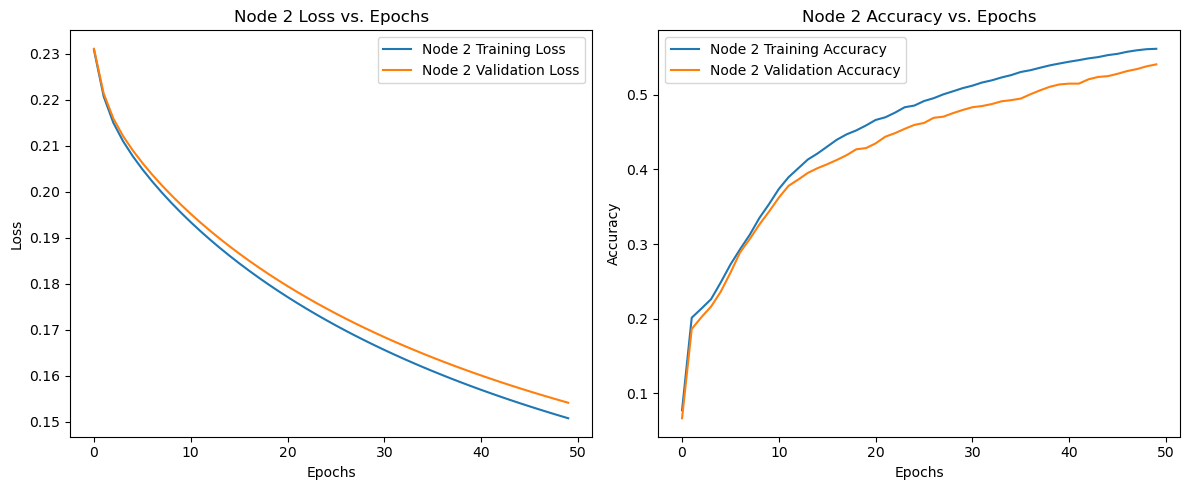

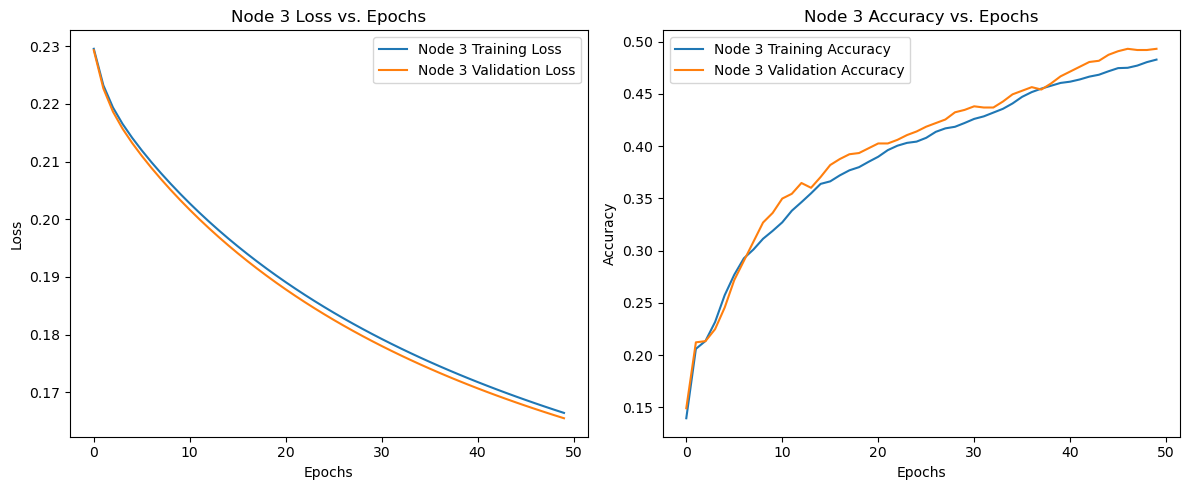

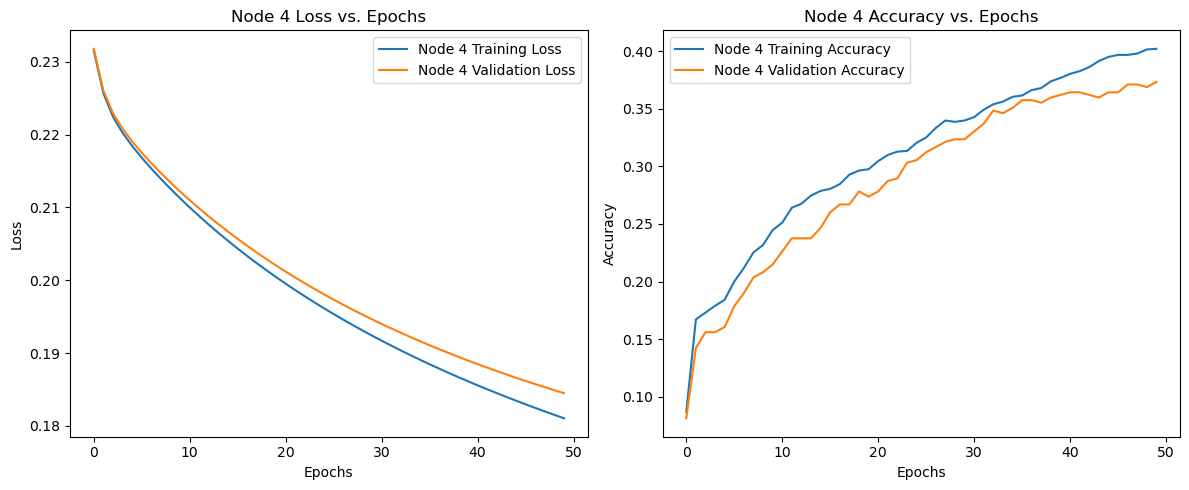

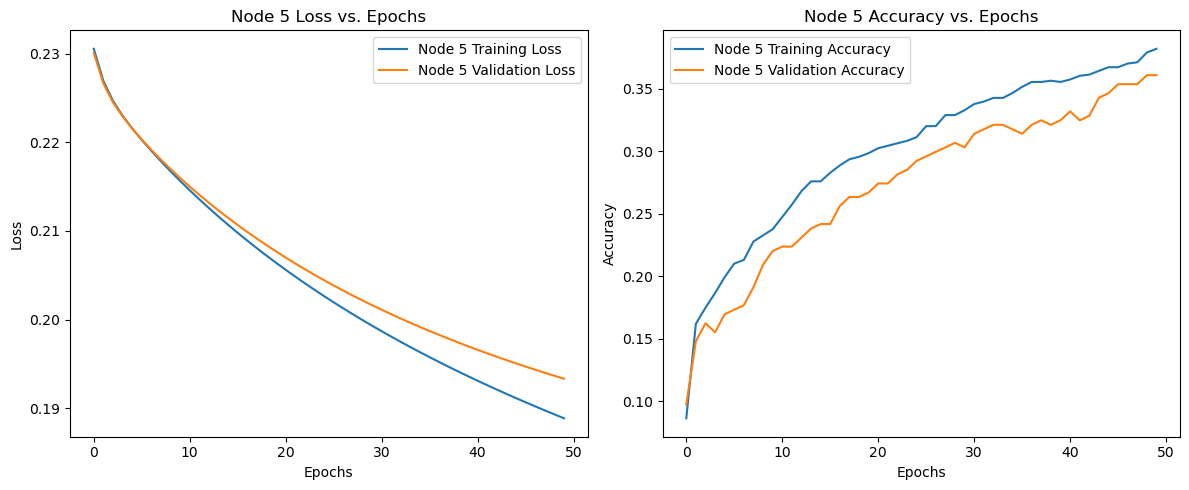

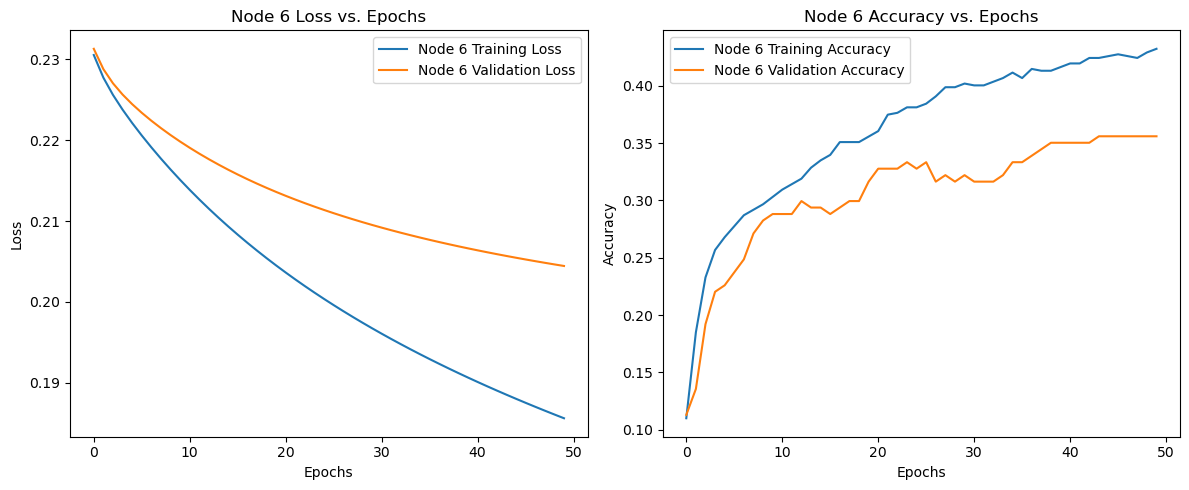

In [57]:
plot_tree_metrics(tree_nn)

In [58]:
tree_nn.summarize()

Node 1:
  Final Training Loss: 0.0802
  Final Validation Loss: 0.0800
  Final Training Accuracy: 0.8414
  Final Validation Accuracy: 0.8407
Node 2:
  Final Training Loss: 0.1508
  Final Validation Loss: 0.1542
  Final Training Accuracy: 0.5613
  Final Validation Accuracy: 0.5405
Node 3:
  Final Training Loss: 0.1665
  Final Validation Loss: 0.1655
  Final Training Accuracy: 0.4828
  Final Validation Accuracy: 0.4931
Node 4:
  Final Training Loss: 0.1810
  Final Validation Loss: 0.1845
  Final Training Accuracy: 0.4020
  Final Validation Accuracy: 0.3733
Node 5:
  Final Training Loss: 0.1889
  Final Validation Loss: 0.1933
  Final Training Accuracy: 0.3821
  Final Validation Accuracy: 0.3610
Node 6:
  Final Training Loss: 0.1856
  Final Validation Loss: 0.2045
  Final Training Accuracy: 0.4322
  Final Validation Accuracy: 0.3559

Overall Model Test Accuracy: 0.8645


In [59]:
def visualize_node_weights(tree_nn):
    for i, (W, b) in enumerate(tree_nn.nodes):
        plt.figure(figsize=(10, 5))
        for j in range(10):  # Assuming 10 classes for MNIST
            plt.subplot(2, 5, j + 1)
            plt.imshow(W[:, j].reshape(28, 28), cmap='viridis')
            plt.title(f'Class {j}')
            plt.axis('off')
        plt.suptitle(f'Node {i + 1} Weights Visualization')
        plt.show()

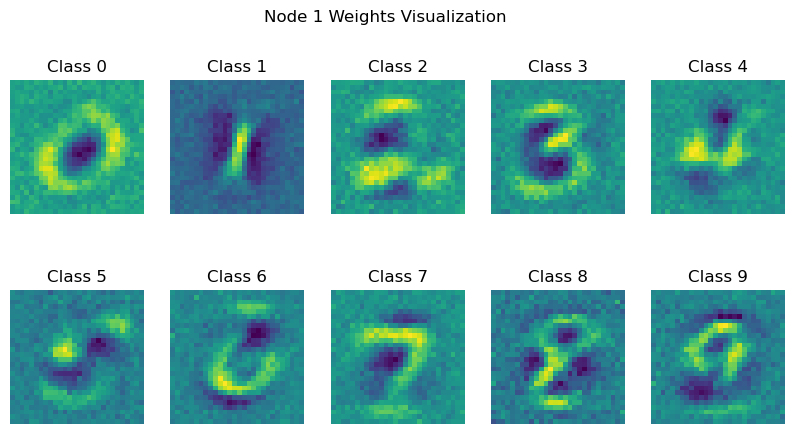

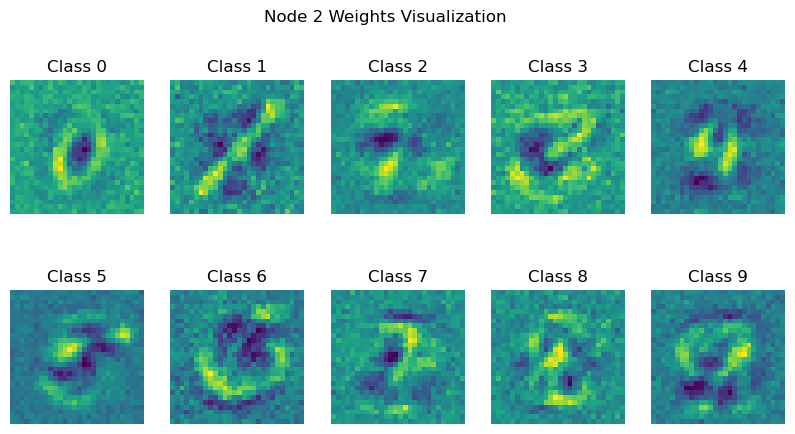

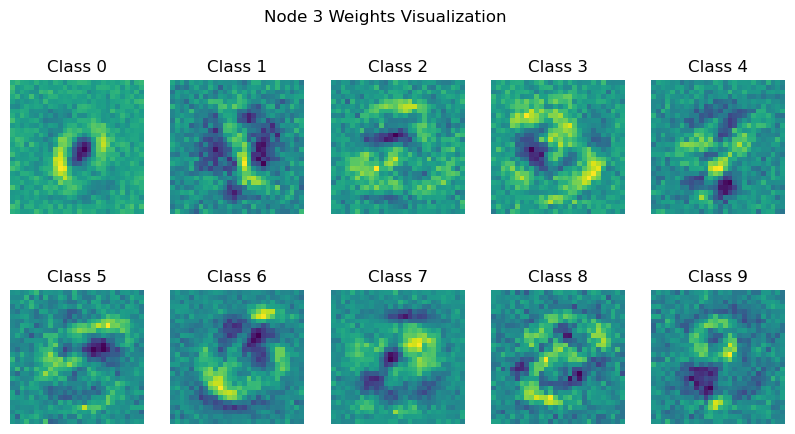

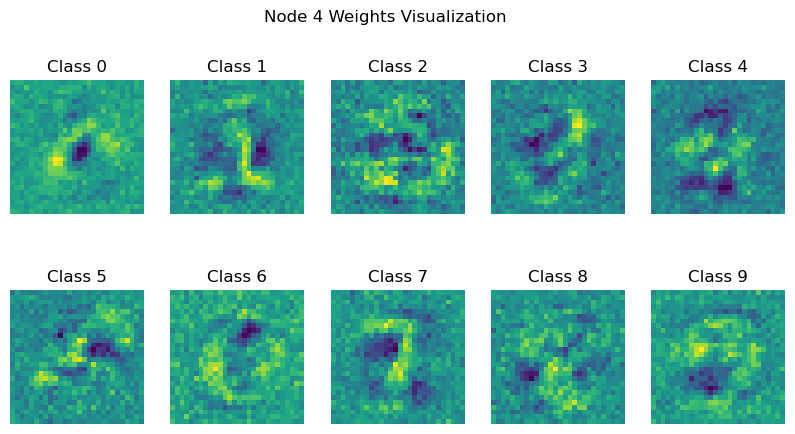

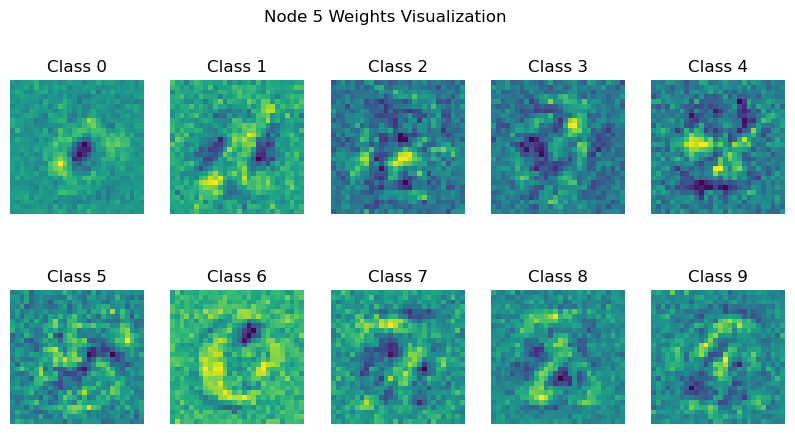

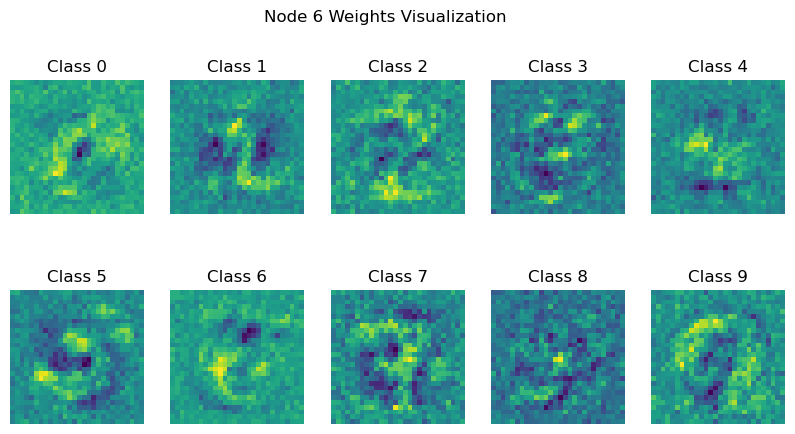

In [60]:
visualize_node_weights(tree_nn)